# Adult Income Dataset, EDA and Classification

## Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna as op
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading and first look to out dataset

In [3]:
df = pd.read_csv('adult.csv')

In [3]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


Let's see what do we got in every column

In [4]:
for columns in df.columns:
    print(df[columns].value_counts())

age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
fnlwgt
164190    13
203488    13
123011    13
113364    12
121124    12
          ..
183522     1
44419      1
442612     1
374833     1
257302     1
Name: count, Length: 21648, dtype: int64
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

Now let's take a closer look to the type of data we have in every column.

In [5]:
i=0
for columns in df.columns:
    if df[columns].dtype == 'object':
        print(f' {columns} is object')
    elif df[columns].dtype == 'category':
        print(f'{columns} is cat')
    elif df[columns].dtype == 'int64':
        print(f'{columns} is num')
    i +=1
print(f'There are {i-1} features columns')


age is num
 workclass is object
fnlwgt is num
 education is object
education.num is num
 marital.status is object
 occupation is object
 relationship is object
 race is object
 sex is object
capital.gain is num
capital.loss is num
hours.per.week is num
 native.country is object
 income is object
There are 14 features columns


Now, let's check if there are null values or not.

In [7]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Since there aren't null values, we do not need to worry about that. Let's continue by dropping columns that are not giving extra info for our analysis. Note the education column is also in a numeric format, so we drop the categorical one, since we can always go back and check the relation between the numbers and the categories.

In [6]:
df = df.drop(columns=['fnlwgt', 'education'])

The task of our classification model will be to predict if an adult income is greater or not than 50K, so we need to modify our income column by mapping the corresponding values to 0 and 1.

In [7]:
df['income'] = df['income'].map({'<=50K' : 0, '>50K' :1})
df

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,?,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0
32557,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32558,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32559,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0


## Some EDA

Let's start checking if there's a relation between education level and income.

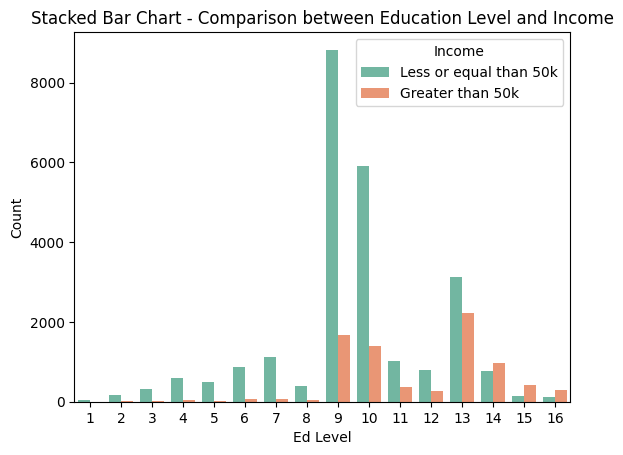

In [12]:
sns.countplot(x='education.num', hue='income', data=df, palette='Set2')

# Set the title and labels
plt.title("Stacked Bar Chart - Comparison between Education Level and Income")
plt.xlabel('Ed Level')
plt.ylabel('Count')

# Modify the legend with custom labels
plt.legend(title='Income', labels=['Less or equal than 50k', 'Greater than 50k'])

# Show the plot
plt.show()


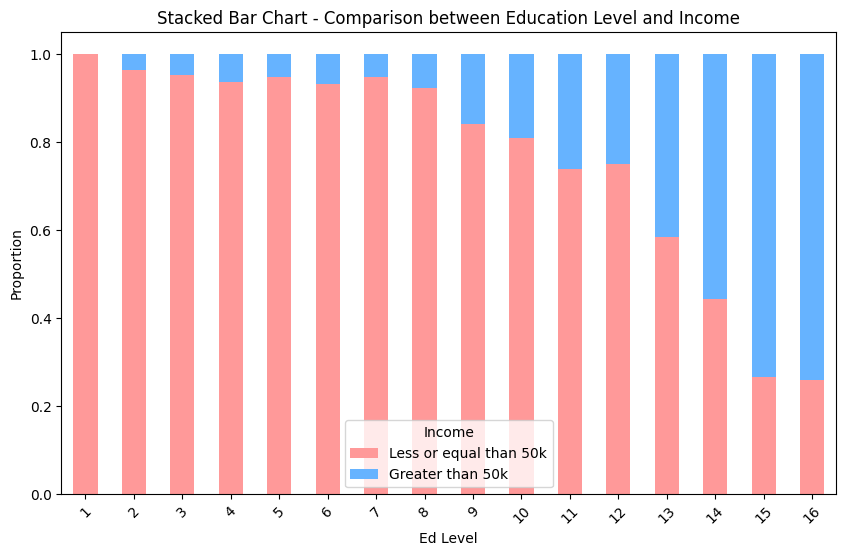

In [13]:


# Calculate the proportions of each binary target (0/1) within each category
df_proportions = pd.crosstab(df['education.num'], df['income'], normalize='index')

# Plot the stacked bar chart with proportions
df_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999', '#66b3ff'])

# Set plot labels and title
plt.title("Stacked Bar Chart - Comparison between Education Level and Income")
plt.xlabel('Ed Level')
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title='Income', labels=['Less or equal than 50k', 'Greater than 50k'])

# Display the plot
plt.show()


As we can see, there's a relation between higher educational level and an income greater than 50k. Let's now check if theres is a relation between sex and income.

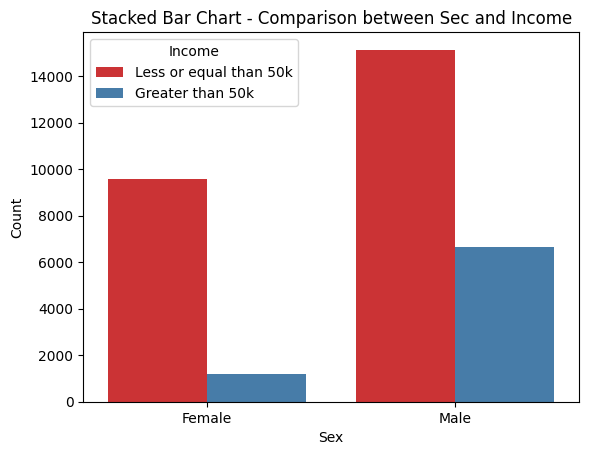

In [14]:
sns.countplot(x='sex', hue='income', data=df, palette='Set1')
plt.title("Stacked Bar Chart - Comparison between Sec and Income")
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Income', labels=['Less or equal than 50k', 'Greater than 50k'])
plt.show()


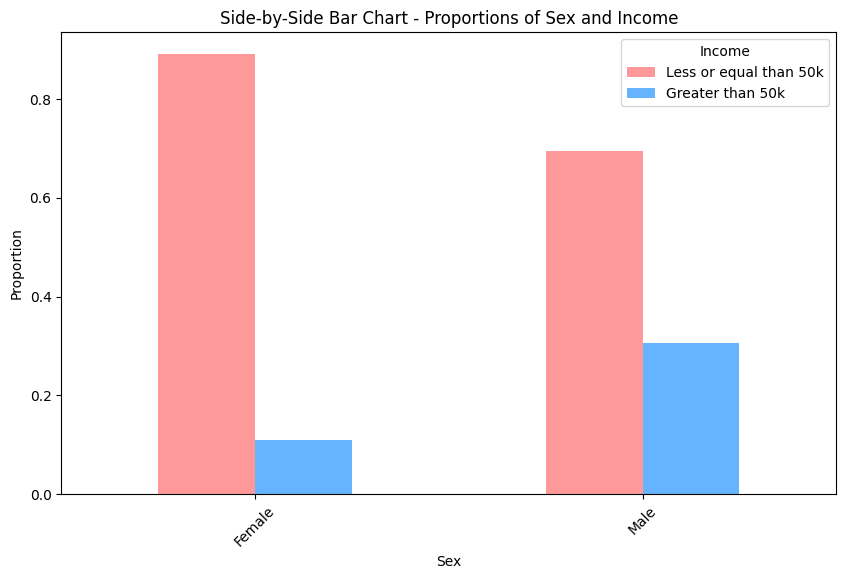

In [ ]:
# Calculate the proportions of each binary target for each category
df_proportions = pd.crosstab(df['sex'], df['income'], normalize='index')

# Plot side-by-side bars (grouped bar plot) with proportions
df_proportions.plot(kind='bar', figsize=(10, 6), color=['#ff9999', '#66b3ff'])

# Set plot labels and title
plt.title("Side-by-Side Bar Chart - Proportions of Sex and Income")
plt.xlabel("Sex")
plt.ylabel("Proportion")
plt.legend(title='Income', labels=['Less or equal than 50k', 'Greater than 50k'])
plt.xticks(rotation=45)

# Display the plot
plt.show()


Based on the graphics, there's a bigger proportion of men earning more than 50k than women.

We shall now check this relation in another way: considering the income on the x-axis and the sex as hue.

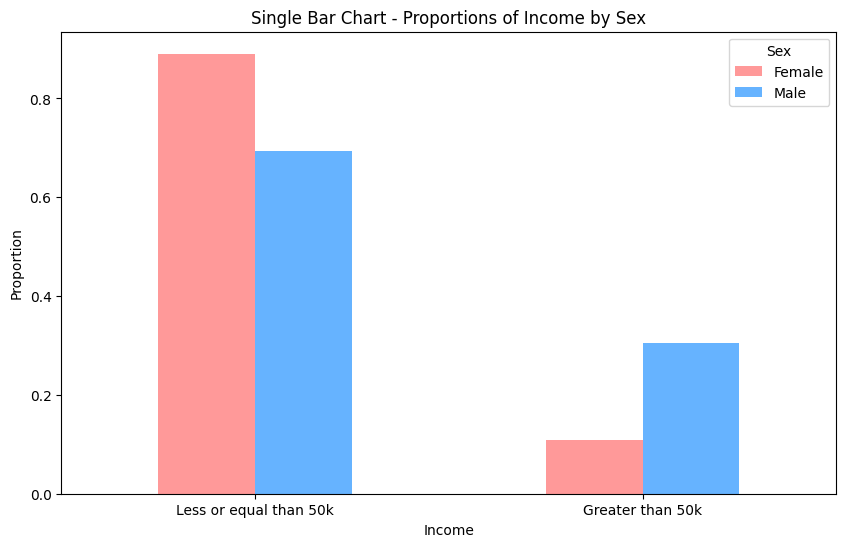

In [19]:
# Calculate the proportions of each binary target for each category
df_proportions = pd.crosstab(df['income'], df['sex'], normalize='columns')

# Plot single bars with proportions
df_proportions.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#ff9999', '#66b3ff'])

# Set plot labels and title
plt.title("Single Bar Chart - Proportions of Income by Sex")
plt.xlabel("Income")
plt.ylabel("Proportion")
plt.legend(title='Sex')
plt.xticks(rotation=0)

cl = ['Less or equal than 50k', 'Greater than 50k']
plt.xticks(ticks=[0,1], labels=cl)

# Display the plot
plt.show()

Let's check a heatmap of proportion about the relation we have been studying. Clearly, there's a relation between the sex and the income.

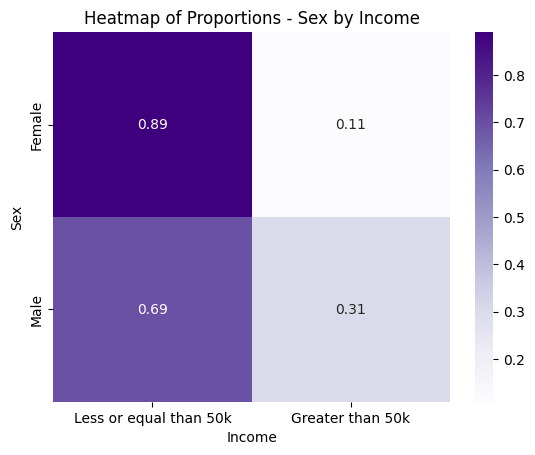

In [28]:
# Calculate the proportions of each binary target (0/1) for each category
df_proportions = pd.crosstab(df['sex'], df['income'], normalize='index')

# Plot the heatmap of proportions
ax = sns.heatmap(df_proportions, annot=True, cmap="Purples", cbar=True, fmt='.2f')

# Set plot labels and title
plt.title("Heatmap of Proportions - Sex by Income")
plt.xlabel("Income")
plt.ylabel("Sex")

cl = ['Less or equal than 50k', 'Greater than 50k']
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels( labels=cl, ha='center')

# Display the plot
plt.show()


Now, we can also wonder about the relation between the income and the age. In fact, this might be an important relation.

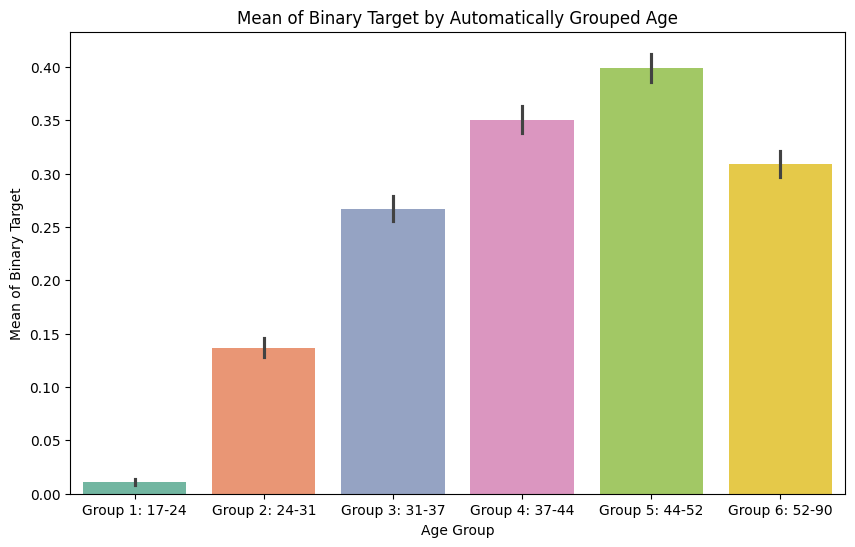

In [ ]:
# Create labels based on the bins
df2 = df.copy()
num_bins = 6  # You can choose the number of bins you want

age_labels = [f'Group {i+1}: {df2["age"].quantile(i/num_bins):.0f}-{df2["age"].quantile((i+1)/num_bins):.0f}' for i in range(num_bins)]

# Create a new 'age_group' column with these labels
df2['age_group'] = pd.qcut(df2['age'], q=num_bins, labels=age_labels)

# Plot again using the descriptive age group labels
plt.figure(figsize=(10,6))

sns.barplot(x='age_group', y='income', data=df2, palette='Set2')

# Add plot title and labels
plt.title('Mean of Binary Target Grouped Age')
plt.xlabel('Age Group')
plt.ylabel('Mean of Binary Target')

# Display the plot
plt.show()

## Data Preparation

Since we have several categorical features, and some of them have quite a bit of categories, encoding this features using OneHotEncoding will result in a big dimensionality, so, we are gonna use TargetEncoder.

In [63]:

# Assuming df is the dataframe and 'income' is the target column
X = df.drop(columns=['income'])
y = df['income']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the encoder
encoder = TargetEncoder()

# Fit on the training set and transform the train and test sets separately
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)


In [53]:
X_train_encoded

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
5514,26,0.218586,9,0.045754,0.226695,0.102371,0.257371,0.307458,0,0,25,0.247309
19777,24,0.218586,9,0.045754,0.040535,0.102371,0.257371,0.109654,0,0,35,0.247309
10781,36,0.218586,13,0.104132,0.131105,0.064260,0.257371,0.109654,0,0,40,0.247309
32240,22,0.271186,10,0.449361,0.131105,0.478365,0.257371,0.109654,0,0,20,0.247309
9876,31,0.294643,13,0.449361,0.452638,0.450852,0.257371,0.307458,0,0,40,0.247309
...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,0.218586,9,0.045754,0.226695,0.014071,0.257371,0.307458,0,0,40,0.247309
5390,51,0.218586,11,0.449361,0.452638,0.450852,0.257371,0.307458,0,0,40,0.247309
860,55,0.382507,9,0.449361,0.300662,0.450852,0.257371,0.307458,0,1887,40,0.247309
15795,41,0.218586,10,0.449361,0.131105,0.450852,0.257371,0.307458,0,0,50,0.247309


Even though there is a big gap between the scales of some features, we are gonna train a tree-based model (LightgbmClassifier), so we don't need to standarize our data.

## Model Training

### First Model Training

In order to find the best parameters for our model, we are gonna use Optuna. Also, we are gonna add some cross validation, in order to avoid overfitting on the training set.

In [31]:
def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "binary",  # Change to binary classification
        "metric": "binary_logloss",  # Use binary_logloss as evaluation metric
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        'verbose': -1,
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Create LightGBM datasets
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Train the model
        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict on validation set (get class probabilities)
        y_pred = model.predict(X_val)
        
        y_pred_classes = (y_pred >= 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)
        # Calculate accuracy for the current fold
        accuracy = accuracy_score(y_val, y_pred_classes)
        accuracy_scores.append(accuracy)

    # Return the mean accuracy over all folds (we want to maximize accuracy)
    return 1 - np.mean(accuracy_scores)  # Optuna minimizes the objective, so we subtract from 1 to maximize accuracy

# Run Optuna
study = op.create_study(direction="minimize")  # Minimize the negative accuracy (maximize accuracy)
study.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")


[I 2025-02-22 13:35:57,208] A new study created in memory with name: no-name-e6c2b9fc-d93e-4dac-8ee0-0ba466038199
[I 2025-02-22 13:36:00,069] Trial 0 finished with value: 0.13041295351431104 and parameters: {'learning_rate': 0.04323574743192012, 'num_leaves': 90, 'max_depth': 6, 'min_data_in_leaf': 19, 'lambda_l1': 3.280046351056855e-06, 'lambda_l2': 0.965051982520952, 'feature_fraction': 0.7165546397635773}. Best is trial 0 with value: 0.13041295351431104.
[I 2025-02-22 13:36:02,455] Trial 1 finished with value: 0.1291076458911915 and parameters: {'learning_rate': 0.04664575138477935, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 36, 'lambda_l1': 2.625781257887081e-07, 'lambda_l2': 2.3440734197899536e-08, 'feature_fraction': 0.9387084341862345}. Best is trial 1 with value: 0.1291076458911915.
[I 2025-02-22 13:36:04,408] Trial 2 finished with value: 0.13225563020447773 and parameters: {'learning_rate': 0.028818316219089795, 'num_leaves': 67, 'max_depth': 8, 'min_data_in_leaf':

Best parameters: {'learning_rate': 0.09449836728349618, 'num_leaves': 33, 'max_depth': 8, 'min_data_in_leaf': 17, 'lambda_l1': 1.1268470801488722e-08, 'lambda_l2': 6.516389078906247e-06, 'feature_fraction': 0.7209736454250628}


Let's check and save the best parameters found by the optimizer so we don't need to run it again later.

In [32]:
best_params

{'learning_rate': 0.09449836728349618,
 'num_leaves': 33,
 'max_depth': 8,
 'min_data_in_leaf': 17,
 'lambda_l1': 1.1268470801488722e-08,
 'lambda_l2': 6.516389078906247e-06,
 'feature_fraction': 0.7209736454250628}

In [110]:
best_params = {"objective": "binary",  # Change to multiclass classification
        "metric": "binary_logloss",  # Use multi_logloss as evaluation metric
        "boosting_type": "gbdt",
        'learning_rate': 0.09449836728349618,
 'num_leaves': 33,
 'max_depth': 8,
 'min_data_in_leaf': 17,
 'lambda_l1': 1.1268470801488722e-08,
 'lambda_l2': 6.516389078906247e-06,
 'feature_fraction': 0.7209736454250628}

Let's train our final model and compute some metrics on the test set.

In [111]:
# Train the final model using the best hyperparameters
best_model = lgb.train(best_params, lgb.Dataset(X_train_encoded, label=y_train))

# Predict on the test set
y_pred_test = best_model.predict(X_test_encoded)

# Convert probabilities to class labels (0 or 1)
y_pred_test_classes = (y_pred_test >= 0.5).astype(int)



In [113]:
# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test_classes)
print(f"Test accuracy: {test_accuracy}")
test_prec = precision_score(y_test, y_pred_test_classes)
print(f"Test precision: {test_prec}")
test_recall = recall_score(y_test, y_pred_test_classes)
print(f"Test recall: {test_recall}")
test_f1 = f1_score(y_test, y_pred_test_classes)
print(f"Test f1_score: {test_f1}")
test_roc = roc_auc_score(y_test, y_pred_test)
print(f'Test roc_auc_score: {test_roc}')

Test accuracy: 0.8710271764163979
Test precision: 0.7763679619349723
Test recall: 0.6369551073519844
Test f1_score: 0.6997855611150822
Test roc_auc_score: 0.9285970184537047


Finally, let's see the confusion matrix on the test set.

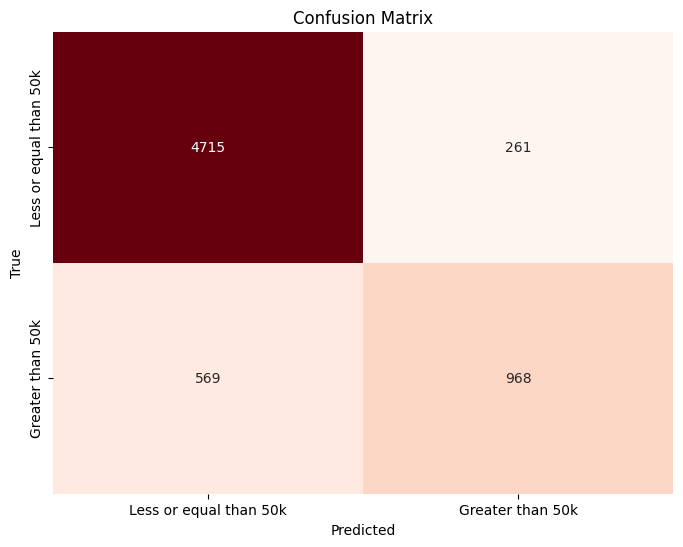

In [38]:

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Less or equal than 50k', 'Greater than 50k'],
            yticklabels=['Less or equal than 50k', 'Greater than 50k'], cbar=False)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


It looks like our classes are imbalanced, so let's take a look at the whole dataset, as well as the test set.

In [44]:
df['income'].value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

In [45]:
y_test.value_counts()

income
0    4976
1    1537
Name: count, dtype: int64

Because of the imbalanced amount over the classes, might be wise to also take a look to the normalized version, in order to get the percentages.

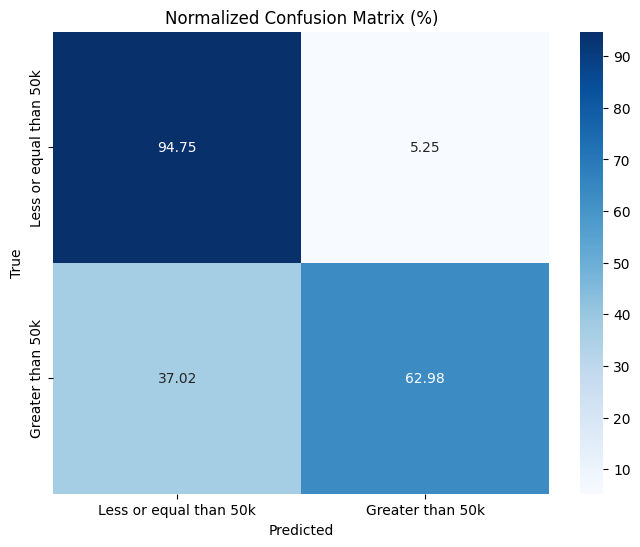

In [47]:


# Normalize by row (true class), converting counts into percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Plot the normalized confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Less or equal than 50k', 'Greater than 50k'],
            yticklabels=['Less or equal than 50k', 'Greater than 50k'], cbar=True)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (%)')

# Show the plot
plt.show()

From the plot, we can see that our model is doing well when having to predict the salaries equal or below 50k, actually around 95% of the data that belongs to that class was correctly predicted. However, is struggling to properly identify those than have an income greater than 50k. This fact could be, as we have seen earlier, of the imbalance amount of data that belong to each class.

Before continuing, we can also see the feature importance of our model.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

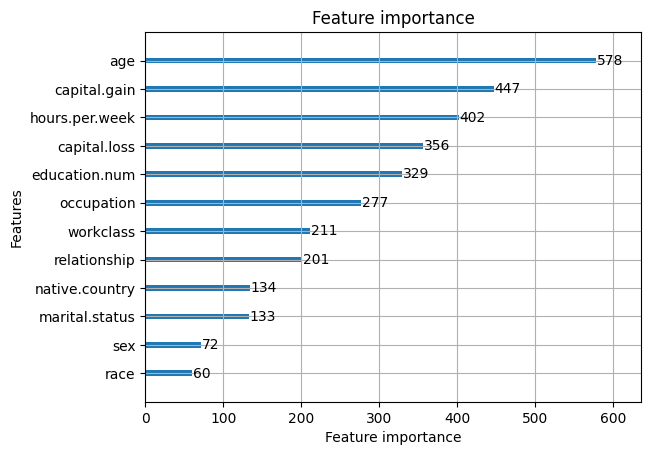

In [74]:
lgb.plot_importance(best_model)

It seems the age is a very important fact and sex is not being considered that important.

### Second Model Training

Let's try to improve our results, knowing the imbalanced situation of the classes. In order to do that, we gonna use an utility from sklearn. Also, instead of accuracy, we gonna train the model with f1_score.

In [ ]:

def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "binary",  # Binary classification
        "metric": "binary_logloss",  # Use binary_logloss as evaluation metric
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "verbose": -1,
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    # Loop over each fold
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Compute class weights for the current fold based on y_tr
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)
        class_weights_dict = dict(zip(np.unique(y_tr), class_weights))  # Create dictionary mapping class to weight
        
        # Create weight arrays for train and validation sets
        train_weights = [class_weights_dict[label] for label in y_tr]
        val_weights = [class_weights_dict[label] for label in y_val]

        # Create LightGBM datasets with weights
        train_data = lgb.Dataset(X_tr, label=y_tr, weight=train_weights)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, weight=val_weights)

        # Train the model
        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict on validation set (get class probabilities)
        y_pred = model.predict(X_val)
        
        y_pred_classes = (y_pred >= 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)
        # Calculate F1 score for the current fold
        f1_sc = f1_score(y_val, y_pred_classes)
        f1_scores.append(f1_sc)

    # Return the mean F1 score to be minimized
    return 1 - np.mean(f1_scores)  # Optuna minimizes, so subtract from 1 to maximize F1

# Run Optuna optimization
study2 = op.create_study(direction="minimize")  # Minimize the negative F1 score
study2.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params2 = study2.best_params
print(f"Best parameters: {best_params2}")


[I 2025-02-22 14:24:32,471] A new study created in memory with name: no-name-4ec4e317-4544-4e7e-a5c0-2540a418e45c
[I 2025-02-22 14:24:33,790] Trial 0 finished with value: 0.2853255748817608 and parameters: {'learning_rate': 0.08590930281896648, 'num_leaves': 96, 'max_depth': 6, 'min_data_in_leaf': 15, 'lambda_l1': 0.0019916464737951235, 'lambda_l2': 2.237481524668002e-06, 'feature_fraction': 0.9443191216127302}. Best is trial 0 with value: 0.2853255748817608.
[I 2025-02-22 14:24:35,282] Trial 1 finished with value: 0.2852215305044098 and parameters: {'learning_rate': 0.15550446439125307, 'num_leaves': 90, 'max_depth': 7, 'min_data_in_leaf': 38, 'lambda_l1': 0.00019127323124895444, 'lambda_l2': 0.0012335828173684732, 'feature_fraction': 0.9692785243214743}. Best is trial 1 with value: 0.2852215305044098.
[I 2025-02-22 14:24:36,619] Trial 2 finished with value: 0.32221686829938645 and parameters: {'learning_rate': 0.011845149706386535, 'num_leaves': 99, 'max_depth': 5, 'min_data_in_leaf'

Best parameters: {'learning_rate': 0.19854042515786555, 'num_leaves': 59, 'max_depth': 8, 'min_data_in_leaf': 50, 'lambda_l1': 0.07546787288212235, 'lambda_l2': 0.477290323855347, 'feature_fraction': 0.6179208018066077}


In [67]:
best_params2

{'learning_rate': 0.19854042515786555,
 'num_leaves': 59,
 'max_depth': 8,
 'min_data_in_leaf': 50,
 'lambda_l1': 0.07546787288212235,
 'lambda_l2': 0.477290323855347,
 'feature_fraction': 0.6179208018066077}

In [114]:
best_params2 = {"objective": "binary",  # Change to multiclass classification
        "metric": "binary_logloss",  # Use multi_logloss as evaluation metric
        "boosting_type": "gbdt",
        'learning_rate': 0.19854042515786555,
 'num_leaves': 59,
 'max_depth': 8,
 'min_data_in_leaf': 50,
 'lambda_l1': 0.07546787288212235,
 'lambda_l2': 0.477290323855347,
 'feature_fraction': 0.6179208018066077}


In [115]:
# Compute class weights using sklearn's compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Map the class labels to their respective computed weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Create a weight vector for training based on the computed class weights
train_weights = y_train.map(class_weight_dict)

# Train the final model using the best hyperparameters
best_model2 = lgb.train(best_params2, 
                        lgb.Dataset(X_train_encoded, label=y_train, weight=train_weights))

# Predict on the test set (no need for weights here, as it's used only during training)
y_pred_test2 = best_model2.predict(X_test_encoded)

# Convert probabilities to class labels (0 or 1)
y_pred_test_classes2 = (y_pred_test2 >= 0.5).astype(int)


In [116]:
# Calculate accuracy on the test set
test_accuracy2 = accuracy_score(y_test, y_pred_test_classes2)
print(f"Test accuracy: {test_accuracy2}")
test_prec2 = precision_score(y_test, y_pred_test_classes2)
print(f"Test precision: {test_prec2}")
test_recall2 = recall_score(y_test, y_pred_test_classes2)
print(f"Test recall: {test_recall2}")
test_f12 = f1_score(y_test, y_pred_test_classes2)
print(f"Test f1_score: {test_f12}")
test_roc2 = roc_auc_score(y_test, y_pred_test2)
print(f'Test roc_auc_score: {test_roc2}')

Test accuracy: 0.8430830646399509
Test precision: 0.6242161119150988
Test recall: 0.8418998048145738
Test f1_score: 0.7168975069252077
Test roc_auc_score: 0.9244078800101254


Let's compare this values with the first's model ones.

In [117]:
# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test_classes)
print(f"Test accuracy: {test_accuracy}")
test_prec = precision_score(y_test, y_pred_test_classes)
print(f"Test precision: {test_prec}")
test_recall = recall_score(y_test, y_pred_test_classes)
print(f"Test recall: {test_recall}")
test_f1 = f1_score(y_test, y_pred_test_classes)
print(f"Test f1_score: {test_f1}")
test_roc = roc_auc_score(y_test, y_pred_test)
print(f'Test roc_auc_score: {test_roc}')

Test accuracy: 0.8710271764163979
Test precision: 0.7763679619349723
Test recall: 0.6369551073519844
Test f1_score: 0.6997855611150822
Test roc_auc_score: 0.9285970184537047


We can see the recall on the test set improved and the precision decreased.


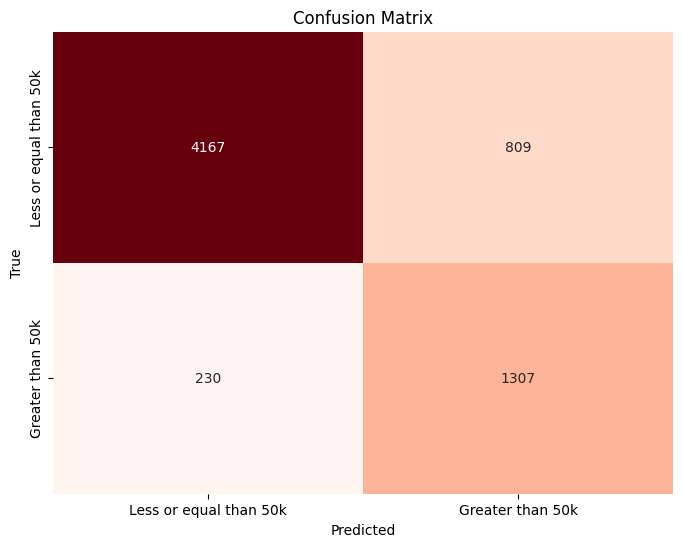

In [205]:

# Calculate the confusion matrix
cm2 = confusion_matrix(y_test, y_pred_test_classes2)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', xticklabels=['Less or equal than 50k', 'Greater than 50k'],
            yticklabels=['Less or equal than 50k', 'Greater than 50k'], cbar=False)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


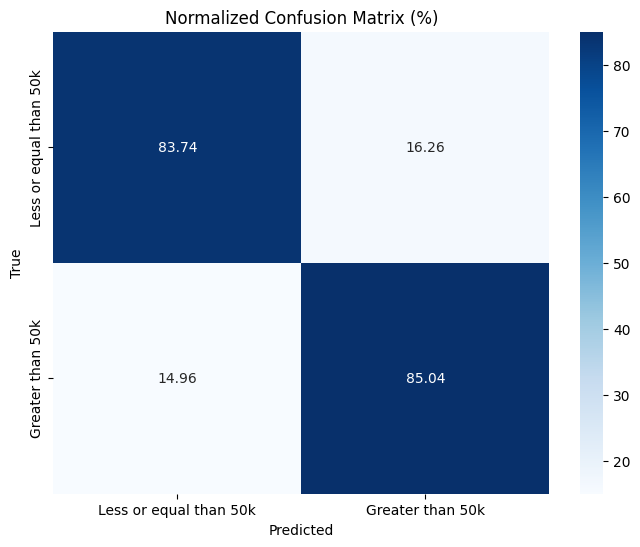

In [206]:


# Normalize by row (true class), converting counts into percentages
cm_normalized2 = cm2.astype('float') / cm2.sum(axis=1, keepdims=True) * 100

# Plot the normalized confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized2, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Less or equal than 50k', 'Greater than 50k'],
            yticklabels=['Less or equal than 50k', 'Greater than 50k'], cbar=True)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (%)')

# Show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

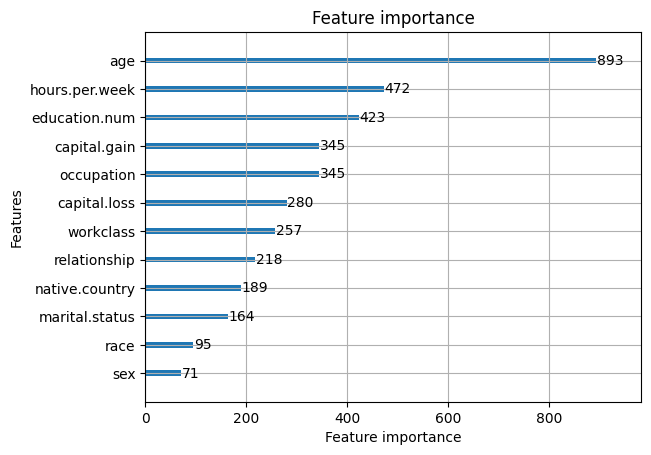

In [130]:
lgb.plot_importance(best_model2)

### Third Model

Let's train our third and final model. In addition to the modifications made on model 2, we are gonna add some extra features using PCA, removing some of them that the model didn't considerer important, and also change the metric. Let's see if this additions helps us or not to improve our model.

In [54]:
def apply_pca(df, pca=None, standardize=True, test=False):
    """
    Apply PCA to a dataset, with an option to fit PCA (train) or transform only (test).

    Parameters:
        X (pd.DataFrame): Input dataset.
        pca (PCA object, optional): Pre-fitted PCA model (required if test=True).
        standardize (bool): Whether to standardize features before applying PCA.
        test (bool): If True, only transform X using the provided pca model.

    Returns:
        If test=False: (PCA model, transformed X, loadings)
        If test=True: transformed X
    """
    X = df.copy()
    # Drop constant columns (zero standard deviation)
    X = X.loc[:, X.std() != 0]

    # Replace infinite values (if any) with NaN and drop them
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    # Standardize only if required
    if standardize:
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)

        # Avoid division by zero
        X_std.replace(0, 1, inplace=True)

        X = (X - X_mean) / X_std

    # If test=True, transform using the provided PCA model
    if test:
        if pca is None:
            raise ValueError("PCA model must be provided when test=True.")
        
        # Ensure no NaN before transformation
        if X.isna().sum().sum() > 0:
            raise ValueError("NaN values detected in the dataset before PCA transformation.")

        X_pca = pca.transform(X)
        component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
        return pd.DataFrame(X_pca, columns=component_names)

    # Otherwise, fit PCA on the training set
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns,
    )

    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [55]:
pca, X_train_pca, loadings = apply_pca(X_train_encoded)
X_test_pca = apply_pca(X_test_encoded, pca=pca, test=True)

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

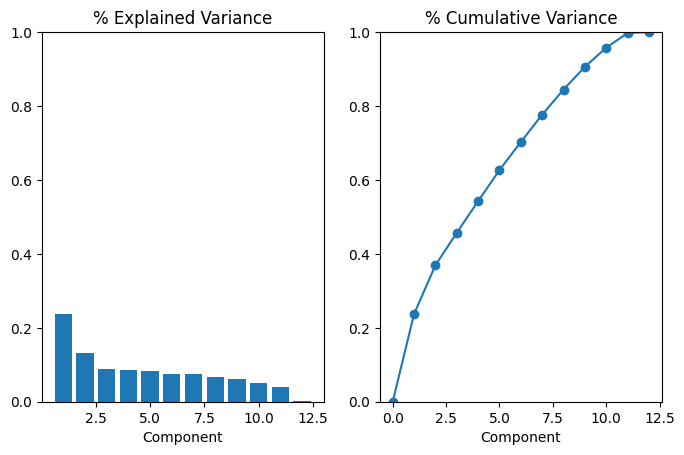

In [56]:
plot_variance(pca)

In [57]:
pca.explained_variance_ratio_

array([0.23738899, 0.13179373, 0.08795424, 0.0855166 , 0.08401662,
       0.07593724, 0.07390791, 0.06808348, 0.06143719, 0.05182652,
       0.03981049, 0.00232698])

In [58]:
np.cumsum(pca.explained_variance_ratio_)

array([0.23738899, 0.36918272, 0.45713696, 0.54265356, 0.62667018,
       0.70260742, 0.77651534, 0.84459881, 0.906036  , 0.95786253,
       0.99767302, 1.        ])

In [67]:
n_pcas = 7  # Change this to the desired number of principal components

# Make sure X_train_encoded and X_train_pca indices align
X_train_pca = X_train_pca.reset_index(drop=True)
X_test_pca = X_test_pca.reset_index(drop=True)

# Add PCA components to the encoded dataset
for i in range(1, n_pcas + 1):
    X_train_encoded[f"PCA{i}"] = X_train_pca[f"PC{i}"].values
    X_test_encoded[f"PCA{i}"] = X_test_pca[f"PC{i}"].values

In [ ]:

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train_encoded)
X_test_s =scaler.transform(X_test_encoded)

X_train_s = pd.DataFrame(X_train_s, columns=X_train_encoded.columns, index=X_train_encoded.index) 
X_test_s = pd.DataFrame(X_test_s, columns=X_test_encoded.columns, index=X_test_encoded.index)

In [95]:
X_train_s = X_train_s.drop(columns=['race', 'sex', 'native.country', 'marital.status'])
X_test_s = X_test_s.drop(columns=['race', 'sex', 'native.country', 'marital.status'])

Let's train the model now.

In [ ]:

def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "binary",  # Binary classification
        "metric": "auc",  # Use ROC AUC as evaluation metric
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "verbose": -1,
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    # Loop over each fold
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train_s.iloc[train_idx], X_train_s.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Compute class weights for the current fold based on y_tr
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)
        class_weights_dict = dict(zip(np.unique(y_tr), class_weights))  # Create dictionary mapping class to weight
        
        # Create weight arrays for train and validation sets
        train_weights = [class_weights_dict[label] for label in y_tr]
        val_weights = [class_weights_dict[label] for label in y_val]

        # Create LightGBM datasets with weights
        train_data = lgb.Dataset(X_tr, label=y_tr, weight=train_weights)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, weight=val_weights)

        # Train the model
        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict on validation set (get class probabilities)
        y_pred = model.predict(X_val)
        
        # Calculate ROC AUC score for the current fold
        auc_sc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc_sc)

    # Return the mean ROC AUC score to be maximized
    return 1 - np.mean(auc_scores)  # Optuna minimizes, so subtract from 1 to maximize AUC

# Run Optuna optimization
study3 = op.create_study(direction="minimize")  # Minimize the negative ROC AUC score
study3.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params3 = study3.best_params
print(f"Best parameters: {best_params3}")


[I 2025-02-23 11:02:54,952] A new study created in memory with name: no-name-1ef48769-5227-4d7f-a718-f6da68be1a19
[I 2025-02-23 11:02:58,977] Trial 0 finished with value: 0.08225569255717846 and parameters: {'learning_rate': 0.02872505848623244, 'num_leaves': 35, 'max_depth': 5, 'min_data_in_leaf': 12, 'lambda_l1': 0.0007580755668129512, 'lambda_l2': 2.198523974287954e-07, 'feature_fraction': 0.9831685949142019}. Best is trial 0 with value: 0.08225569255717846.
[I 2025-02-23 11:03:03,522] Trial 1 finished with value: 0.08261473130942676 and parameters: {'learning_rate': 0.023733871059481805, 'num_leaves': 100, 'max_depth': 7, 'min_data_in_leaf': 45, 'lambda_l1': 0.09083307377409752, 'lambda_l2': 1.952911258079435e-05, 'feature_fraction': 0.9165409567876918}. Best is trial 0 with value: 0.08225569255717846.
[I 2025-02-23 11:03:08,364] Trial 2 finished with value: 0.0744053441769047 and parameters: {'learning_rate': 0.11006743150947747, 'num_leaves': 74, 'max_depth': 8, 'min_data_in_leaf

Best parameters: {'learning_rate': 0.08376217708076765, 'num_leaves': 24, 'max_depth': 10, 'min_data_in_leaf': 32, 'lambda_l1': 1.0471793831756564e-08, 'lambda_l2': 2.1536640933619566e-07, 'feature_fraction': 0.6738589351030912}


In [102]:
best_params3

{'learning_rate': 0.08376217708076765,
 'num_leaves': 24,
 'max_depth': 10,
 'min_data_in_leaf': 32,
 'lambda_l1': 1.0471793831756564e-08,
 'lambda_l2': 2.1536640933619566e-07,
 'feature_fraction': 0.6738589351030912}

In [103]:
best_params3 = {"objective": "binary",  # Change to multiclass classificationdf2
        "metric": "binary_logloss",  # Use multi_logloss as evaluation metric
        "boosting_type": "gbdt",
        'learning_rate': 0.08376217708076765,
 'num_leaves': 24,
 'max_depth': 10,
 'min_data_in_leaf': 32,
 'lambda_l1': 1.0471793831756564e-08,
 'lambda_l2': 2.1536640933619566e-07,
 'feature_fraction': 0.6738589351030912}

In [104]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Create a weight vector for training
train_weights = y_train.map(class_weight_dict)

# Train the final LightGBM model with the best hyperparameters
best_model3 = lgb.train(best_params3, 
                        lgb.Dataset(X_train_s, label=y_train, weight=train_weights))

# Predict probabilities on the test set
y_pred_test3 = best_model3.predict(X_test_s)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_test3)
print(f"ROC AUC Score: {roc_auc}")


ROC AUC Score: 0.9281863942369045


In [118]:
# Calculate accuracy on the test set
y_pred_test_classes3 = (y_pred_test3 >= 0.5).astype(int)

test_accuracy3 = accuracy_score(y_test, y_pred_test_classes3)
print(f"Test accuracy: {test_accuracy3}")
test_prec3 = precision_score(y_test, y_pred_test_classes3)
print(f"Test precision: {test_prec3}")
test_recall3 = recall_score(y_test, y_pred_test_classes3)
print(f"Test recall: {test_recall3}")
test_f13 = f1_score(y_test, y_pred_test_classes3)
print(f"Test f1_score: {test_f13}")
test_roc3 = roc_auc_score(y_test, y_pred_test3)
print(f'Test roc_auc_score: {test_roc3}')

Test accuracy: 0.8329494856440964
Test precision: 0.6023711810305518
Test recall: 0.8594664931685101
Test f1_score: 0.7083109919571046
Test roc_auc_score: 0.9281863942369045


Let's see how this compares with the second model

In [119]:
# Calculate accuracy on the test set
test_accuracy2 = accuracy_score(y_test, y_pred_test_classes2)
print(f"Test accuracy: {test_accuracy2}")
test_prec2 = precision_score(y_test, y_pred_test_classes2)
print(f"Test precision: {test_prec2}")
test_recall2 = recall_score(y_test, y_pred_test_classes2)
print(f"Test recall: {test_recall2}")
test_f12 = f1_score(y_test, y_pred_test_classes2)
print(f"Test f1_score: {test_f12}")
test_roc2 = roc_auc_score(y_test, y_pred_test2)
print(f'Test roc_auc_score: {test_roc2}')

Test accuracy: 0.8430830646399509
Test precision: 0.6242161119150988
Test recall: 0.8418998048145738
Test f1_score: 0.7168975069252077
Test roc_auc_score: 0.9244078800101254


Let's compare this values with the first's model ones.

In [120]:
# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test_classes)
print(f"Test accuracy: {test_accuracy}")
test_prec = precision_score(y_test, y_pred_test_classes)
print(f"Test precision: {test_prec}")
test_recall = recall_score(y_test, y_pred_test_classes)
print(f"Test recall: {test_recall}")
test_f1 = f1_score(y_test, y_pred_test_classes)
print(f"Test f1_score: {test_f1}")
test_roc = roc_auc_score(y_test, y_pred_test)
print(f'Test roc_auc_score: {test_roc}')

Test accuracy: 0.8710271764163979
Test precision: 0.7763679619349723
Test recall: 0.6369551073519844
Test f1_score: 0.6997855611150822
Test roc_auc_score: 0.9285970184537047


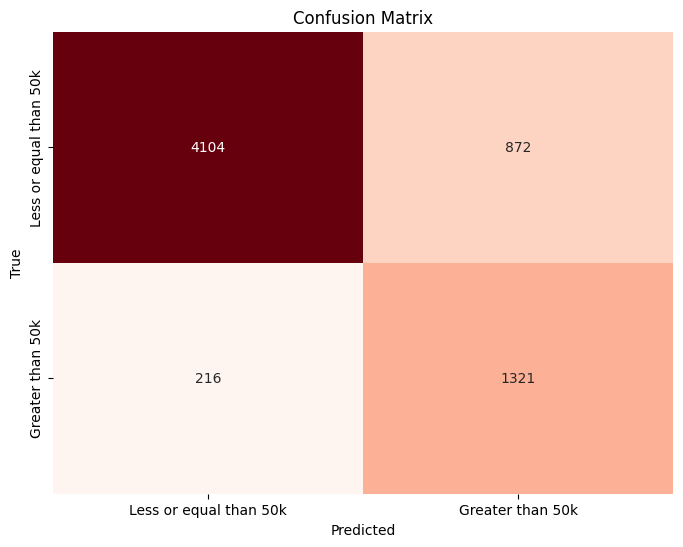

In [106]:

# Calculate the confusion matrix
cm3 = confusion_matrix(y_test, y_pred_test_classes3)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Reds', xticklabels=['Less or equal than 50k', 'Greater than 50k'],
            yticklabels=['Less or equal than 50k', 'Greater than 50k'], cbar=False)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


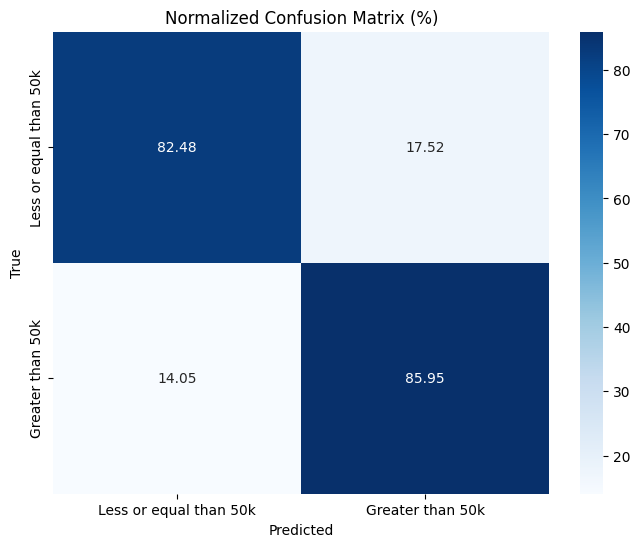

In [107]:


# Normalize by row (true class), converting counts into percentages
cm_normalized3 = cm3.astype('float') / cm3.sum(axis=1, keepdims=True) * 100

# Plot the normalized confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized3, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Less or equal than 50k', 'Greater than 50k'],
            yticklabels=['Less or equal than 50k', 'Greater than 50k'], cbar=True)

# Adding labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (%)')

# Show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

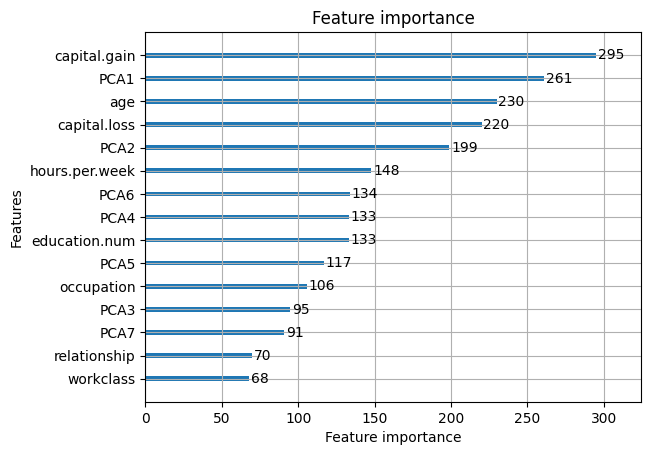

In [121]:
lgb.plot_importance(best_model3)

In conclusion, third model got some extra tweaks on his parameters and achieved a little improvement on the recall score and roc_auc_score but saw a decreased on the other metrics. So between the three models, it really depends which metric we wanna maximize. Also, improvements like field domain feature engineering, trying out different encodings or model are options to try out in order to improve the performance of the model.

Thanks for reading! Fernan ZL